In [1]:
import argparse
from collections import defaultdict
import cv2
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import scipy.stats
import tensorflow as tf
from tqdm import tqdm

import edl
import models


In [2]:
cm = 1/2.54  # centimeters in inches
sns.set()
sns.set_style("white")
sns.set_style("ticks")
sns.despine(trim=True)
sns.set_context("paper")
sns.color_palette("tab10")
output_dir = "figs/depth"

class Model(Enum):
    GroundTruth = "GroundTruth"
    Dropout = "Dropout"
    Ensemble = "Ensemble"
    Evidential = "Evidential"
    Gaussian = "Gaussian"
    Laplace = "Laplace"


<Figure size 432x288 with 0 Axes>

In [6]:
df_image.head()


,Method,Model Path,Target,Mu,Sigma,Adv. Mask,Epsilon,OOD,data_type
0,Evidential,evidence/trial1.h5,"[[[0.28235295], [0.28235295], [0.28235295], [0...","[[[0.27374482], [0.27437437], [0.27264866], [0...","[[[0.018068407], [0.014982495], [0.012448455],...","[[[1, 1, -1], [-1, -1, -1], [-1, 1, -1], [-1, ...",0.0,False,Clean
1,Evidential,evidence/trial1.h5,"[[[0.3882353], [0.3882353], [0.39215687], [0.3...","[[[0.5689936], [0.58620566], [0.54667366], [0....","[[[0.17303167], [0.16977127], [0.20568253], [0...","[[[-1, 1, 1], [-1, 1, 1], [-1, -1, -1], [-1, -...",0.0,False,Clean
2,Evidential,evidence/trial1.h5,"[[[0.40392157], [0.40392157], [0.40392157], [0...","[[[0.36962304], [0.37129945], [0.37162971], [0...","[[[0.046206433], [0.054429606], [0.054412816],...","[[[-1, -1, 1], [-1, 1, 1], [-1, 1, -1], [-1, 1...",0.0,False,Clean
3,Evidential,evidence/trial1.h5,"[[[0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0...","[[[0.37152228], [0.3792064], [0.38220924], [0....","[[[0.077216975], [0.08796246], [0.08727978], [...","[[[1, 1, -1], [-1, -1, -1], [-1, 1, -1], [1, 1...",0.0,False,Clean
4,Evidential,evidence/trial1.h5,"[[[0.4117647], [0.4117647], [0.4117647], [0.41...","[[[0.35355842], [0.3598906], [0.37076262], [0....","[[[0.020483024], [0.016933534], [0.016799815],...","[[[1, 1, -1], [-1, -1, -1], [-1, 1, -1], [-1, ...",0.0,False,Clean


In [3]:


def df_image_to_pixels(df, keys=["Target", "Mu", "Sigma"]):
    required_keys = ["Method", "Model Path"]
    keys = required_keys + keys
    key_types = {key: type(df[key].iloc[0]) for key in keys}
    max_shape = max([np.prod(np.shape(df[key].iloc[0])) for key in keys])

    contents = {}
    for key in keys:
        if np.prod(np.shape(df[key].iloc[0])) == 1:
            contents[key] = np.repeat(df[key], max_shape)
        else:
            contents[key] = np.stack(df[key], axis=0).flatten()

    df_pixel = pd.DataFrame(contents)
    return df_pixel


In [4]:

def gen_interval_score_plot(df_image):
    print(f"Generating Interval score")
    #df = df_image[(df_image["OOD"]==False) & ((df_image["Epsilon"]==0.0) | (df_image["Epsilon"]==0.02) | (df_image["Epsilon"]==0.04))]
    df = df_image[(df_image["OOD"]==False) & (df_image["Epsilon"]==0.0)]
    # df = df.iloc[::10]
    df_pixel = df_image_to_pixels(df, keys=["Target", "Mu", "Sigma", "Epsilon"])

    #print ("Unique Adv : ", df_pixel["Epsilon"].unique())

    print ("Generating RMSE Score")
    df_pixel["RMSE"] = (df_pixel["Mu"] - df_pixel["Target"])**2
    #g = sns.catplot(x="Epsilon", y="RMSE", hue="Method", data=df_pixel, kind="box", whis=0.5, showfliers=False)
    #g.set(yscale="log")
    #plt.savefig(os.path.join(output_dir, f"RMSE_Adv_box_depth_logscale.pdf"))
    plt.show()

    g = sns.catplot(x="Epsilon", y="RMSE", hue="Method", data=df_pixel, kind="box", whis=0.5, showfliers=False)
    #plt.savefig(os.path.join(output_dir, f"RMSE_Adv_box_depth.pdf"))
    plt.show()

    print (f"Generating Interval Score")
    df_pixel["lower"] = df_pixel["Mu"] - 2*df_pixel["Sigma"]
    df_pixel["lower"].mask(df_pixel["Method"]=="Laplace", df_pixel["Mu"] - 3*df_pixel["Sigma"], inplace=True)
    df_pixel["upper"] = df_pixel["Mu"] + 2*df_pixel["Sigma"]
    df_pixel["upper"].mask(df_pixel["Method"]=="Laplace", df_pixel["Mu"] + 3*df_pixel["Sigma"], inplace=True)
    
    df_pixel["Interval Score"] = df_pixel["upper"] - df_pixel["lower"] \
     + (2/0.95)*(df_pixel["lower"]-df_pixel["Target"])*(df_pixel["Target"]<df_pixel["lower"]) \
     + (2/0.95)*(df_pixel["Target"] - df_pixel["upper"])*(df_pixel["Target"]>df_pixel["upper"])
    
    g = sns.catplot(x="Epsilon", y="Interval Score", hue="Method", data=df_pixel, kind="box", whis=0.5, showfliers=False)
    #g.set(yscale="log")
    #plt.savefig(os.path.join(output_dir, f"Interval_score_Adv_box_depth.pdf"))
    plt.show()
 


Generating Interval score
Generating RMSE Score


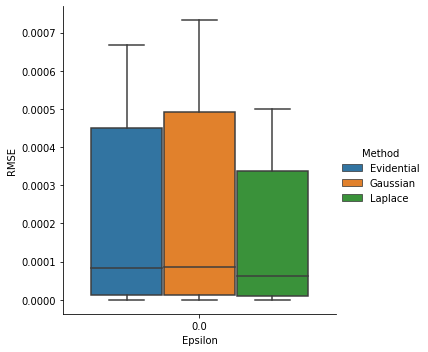

Generating Interval Score


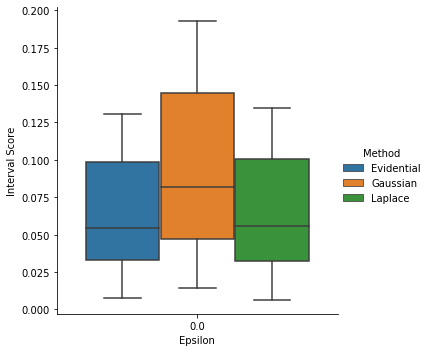

In [5]:
df_noisy = pd.read_pickle("clean_cached_depth_results.pkl")
gen_interval_score_plot(df_noisy)

Generating Interval score
Generating RMSE Score


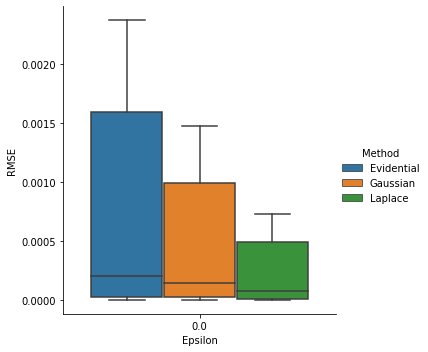

Generating Interval Score


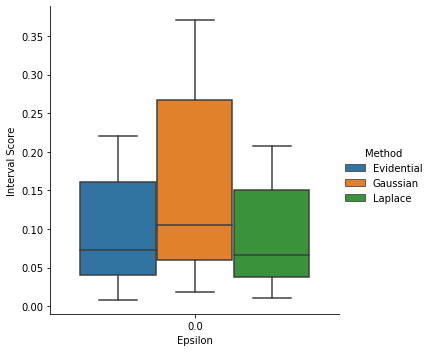

In [6]:
df_image = pd.read_pickle("noisy_cached_depth_results.pkl")
gen_interval_score_plot(df_image)

In [14]:
df_image.columns

Index(['Method', 'Model Path', 'Target', 'Mu', 'Sigma', 'Adv. Mask', 'Epsilon',
       'OOD'],
      dtype='object')

In [4]:
df_clean = pd.read_pickle("clean_cached_depth_results.pkl")
df_noisy = pd.read_pickle("noisy_cached_depth_results.pkl")
df_noisy['data_type'] = 'Noisy'

df_noisy_single = df_noisy[(df_noisy['Model Path'] == 'evidence/trial3.h5') |
                           (df_noisy['Model Path'] == 'gaussian/trial3.h5') | 
                           (df_noisy['Model Path'] == 'laplace/trial1.h5')] 
df_clean['data_type'] = 'Clean'

df_image = pd.concat([df_clean, df_noisy])
#df_image.head()
del df_clean, df_noisy, df_noisy_single


In [5]:
df = df_image[(df_image["OOD"]==False) & (df_image["Epsilon"]==0.0)]
# df = df.iloc[::10]
df_pixel = df_image_to_pixels(df, keys=["Target", "Mu", "Sigma", "data_type"])
print (df_pixel.head())

print ("Generating RMSE Score")
df_pixel["RMSE"] = (df_pixel["Mu"] - df_pixel["Target"])**2

print (f"Generating Interval Score")
df_pixel["lower"] = df_pixel["Mu"] - 2*df_pixel["Sigma"]
df_pixel["lower"].mask(df_pixel["Method"]=="Laplace", df_pixel["Mu"] - 3*df_pixel["Sigma"], inplace=True)
df_pixel["upper"] = df_pixel["Mu"] + 2*df_pixel["Sigma"]
df_pixel["upper"].mask(df_pixel["Method"]=="Laplace", df_pixel["Mu"] + 3*df_pixel["Sigma"], inplace=True)

df_pixel["Interval Score"] = df_pixel["upper"] - df_pixel["lower"] \
 + (2/0.95)*(df_pixel["lower"]-df_pixel["Target"])*(df_pixel["Target"]<df_pixel["lower"]) \
 + (2/0.95)*(df_pixel["Target"] - df_pixel["upper"])*(df_pixel["Target"]>df_pixel["upper"])
    

       Method          Model Path    Target        Mu     Sigma data_type
0  Evidential  evidence/trial1.h5  0.282353  0.273745  0.018068     Clean
0  Evidential  evidence/trial1.h5  0.282353  0.274374  0.014982     Clean
0  Evidential  evidence/trial1.h5  0.282353  0.272649  0.012448     Clean
0  Evidential  evidence/trial1.h5  0.282353  0.277323  0.012150     Clean
0  Evidential  evidence/trial1.h5  0.282353  0.277037  0.011917     Clean
Generating RMSE Score
Generating Interval Score


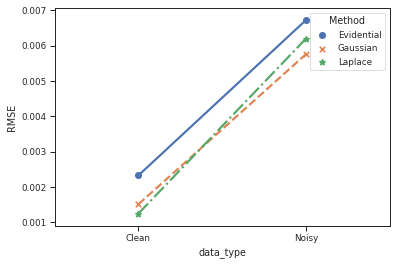

In [14]:
cm = 1/2.54  # centimeters in inches
sns.set()
sns.set_style("white")
sns.set_style("ticks")
sns.despine(trim=True)
sns.set_context("paper")
sns.color_palette("tab10")

#fig = plt.figure(figsize=(14.2*cm, 14.2*cm/2.0))
#gs = fig.add_gridspec(1, 2)
#ax1 = fig.add_subplot(gs[0, 0])

g = sns.pointplot(x="data_type", y="RMSE", hue="Method", 
                  markers=["o", "x", "*", "D"],
                  linestyles=["-","--","-.",":"],
                   data=df_pixel, legend=False)
g.set(yscale="log")

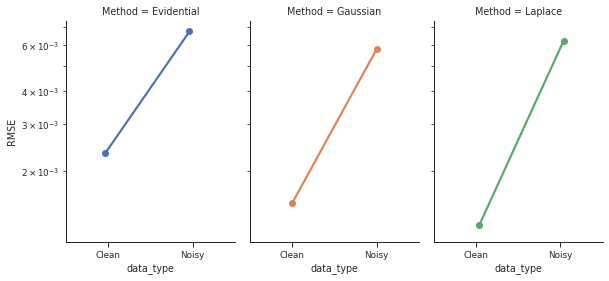

In [15]:
g = sns.catplot(x="data_type", y="RMSE",
                hue="Method", col="Method",
                data=df_pixel, kind="point",
                dodge=True,
                height=4, aspect=.7);
g.set(yscale="log")

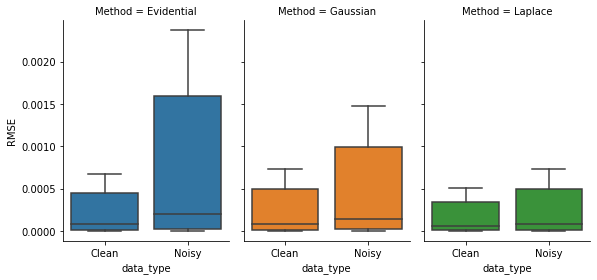

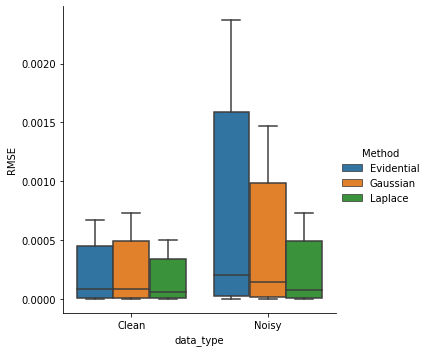

In [19]:

fig = plt.figure(figsize=(14.2*cm, 14.2*cm/2.0))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.catplot(x="data_type", y="RMSE",
                hue="Method", col="Method",
                data=df_pixel, kind="box",
                whis=0.5, showfliers=False,dodge=False,
                height=4, aspect=.7);

g = sns.catplot(x="data_type", y="RMSE", 
                hue="Method", data=df_pixel, 
                kind="box", dodge=True, whis=0.5, showfliers=False)


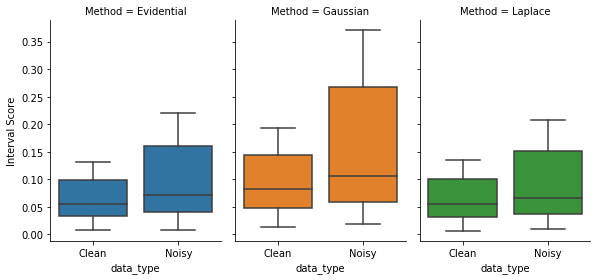

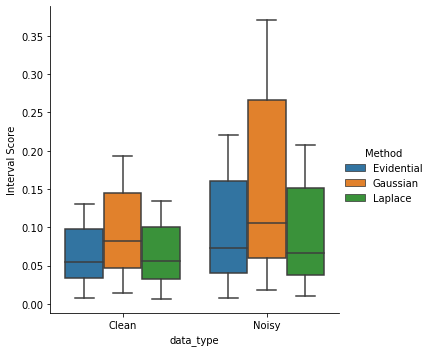

In [20]:
g = sns.catplot(x="data_type", y="Interval Score",
                hue="Method", col="Method",
                data=df_pixel, kind="box",
                whis=0.5, showfliers=False, dodge=False,
                height=4, aspect=.7);

g = sns.catplot(x="data_type", y="Interval Score", 
                hue="Method", data=df_pixel, 
                kind="box", dodge=True, whis=0.5, showfliers=False)


/home/dnair2m/miniconda3/envs/evidence/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/dnair2m/miniconda3/envs/evidence/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


<Figure size 432x288 with 0 Axes>

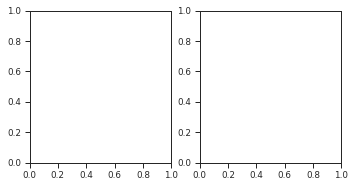

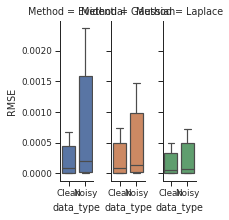

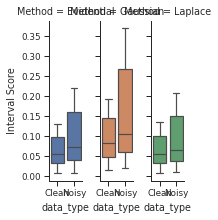

In [9]:


g = sns.catplot(x="data_type", y="RMSE",
                hue="Method", col="Method",
                data=df_pixel, kind="box",
                whis=0.5, showfliers=False,dodge=False,
                aspect=.3, height=14.2*cm/2.0);
plt.savefig(os.path.join(output_dir, f"comparison_rmse.pdf"))
ax1 = fig.add_subplot(gs[0, 1])

g = sns.catplot(x="data_type", y="Interval Score",
                hue="Method", col="Method",
                data=df_pixel, kind="box",
                whis=0.5, showfliers=False,dodge=False,
                aspect=.3, height=14.2*cm/2.0);
plt.savefig(os.path.join(output_dir, f"comparison_rmse.pdf"))


/home/dnair2m/miniconda3/envs/evidence/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


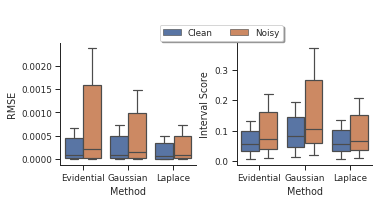

In [21]:
fig = plt.figure(figsize=(14.2*cm, 14.2*cm/2.5))
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.3, hspace=0.5) # set the spacing between axes. 
ax1 = fig.add_subplot(gs[0, 0])
g = sns.boxplot(x="Method", y="RMSE",
                hue="data_type",
                data=df_pixel,
                whis=0.5, showfliers=False,dodge=True, ax=ax1)
                #aspect=1.0, height=14.2*cm/2.0);
sns.despine()
g.get_legend().remove()
handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.55, 0.98), loc='lower center', ncol=3, fancybox=True, shadow=True)

#plt.savefig(os.path.join(output_dir, f"comparison_rmse.pdf"))

ax2 = fig.add_subplot(gs[0, 1])
g = sns.boxplot(x="Method", y="Interval Score",
                hue="data_type",
                data=df_pixel,
                whis=0.5, showfliers=False,dodge=True, ax=ax2)
                #aspect=1.0, height=14.2*cm/2.0);
sns.despine()
g.get_legend().remove()
plt.tight_layout()

plt.savefig(os.path.join(output_dir, f"comparison_IS_rmse.pdf"), bbox_inches='tight')
plt.show()


In [12]:
from IPython.display import Audio
sound_file = '/usr/share/sounds/KDE-Im-Phone-Ring.wav'
Audio(sound_file, autoplay=True)

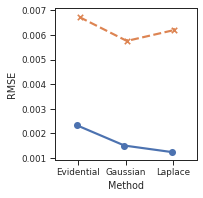

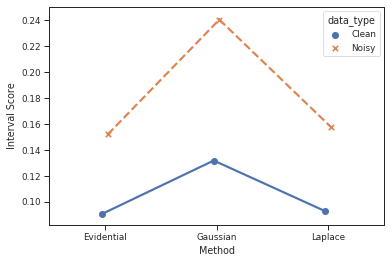

In [9]:

fig = plt.figure(figsize=(14.2*cm, 14.2*cm/2.0))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.pointplot(x="Method", y="RMSE", hue="data_type", 
                  markers=["o", "x", "*", "D"],
                  linestyles=["-","--","-.",":"],
                   data=df_pixel, legend=False, dodge=True,
                aspect=1.0, height=14.2*cm/2.0);
g.get_legend().remove()
plt.savefig(os.path.join(output_dir, f"comparison_rmse_point.pdf"))
plt.show()
ax1 = fig.add_subplot(gs[0, 1])

g = sns.pointplot(x="Method", y="Interval Score", hue="data_type", 
                  markers=["o", "x", "*", "D"],
                  linestyles=["-","--","-.",":"],
                   data=df_pixel, legend=False, dodge=True,
                aspect=1.0, height=14.2*cm/2.0);
plt.savefig(os.path.join(output_dir, f"comparison_IS_point.pdf"))
plt.show()